In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
## read the movieLens data from csv file
df=pd.read_csv('./source_data/ml-latest-small/ratings.csv')

In [3]:
## have a glance of the data
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# there are 10 different ratings from 0.5 to 5
df.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

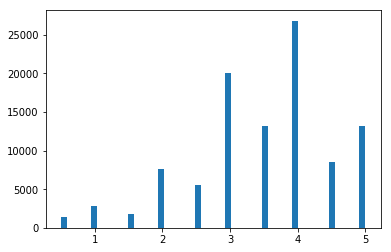

In [5]:
## have a look at the distribution of the data, skewed to the right
fig=plt.figure()
plt.hist(df.rating,50)
plt.show()

In [7]:
## dataset overview
n_users=df.userId.nunique()
n_items=df.movieId.nunique()
n_ratings=len(df)
print('there are total %d users, %d movies and %d ratings'%(n_users,n_items,n_ratings))

there are total 610 users, 9724 movies and 100836 ratings


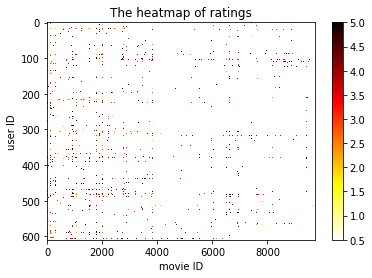

In [8]:
## have a look at the heatmap of the dataset, the data is very sparse
pivot=pd.pivot_table(df,index=['userId'],columns=['movieId'], values=['rating'])
fig = plt.figure()
plt.imshow(pivot,cmap=plt.cm.hot_r,aspect='auto')
plt.colorbar()
plt.xlabel('movie ID')
plt.ylabel('user ID')
plt.title('The heatmap of ratings')
plt.show()

In [9]:
## the code of Matrix Factorization (SVD stands for sigular vector decomposition) for recommender system
class SVD():
    def __init__(self, n_factors=10, biased=True, init_mean=0,
                 init_std_dev=.1,lr=.005,reg=.005):
        ## define some hyperparameters
        self.n_factors = n_factors
        self.biased = biased
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr=lr
        self.reg=reg
       
        
    def process_data(self,data, train_proportion=0.8):
        
        ## we suppose the format of data is pandas dataframe, 
        ## we first shuffle the data, then split it into the train and test set.
        ## we give the new user ID and movie ID to the training set, so the new ID 
        ## starts from 0, and is cumulated by 1. There is no jump along the IDs.
        
        n_ratints=len(data)
        df = data.sample(frac=1)
        split_pos=int(np.ceil(n_ratints*train_proportion))
        trainset=df.iloc[:split_pos]
        testset=df.iloc[split_pos:]
        
        
        self.global_mean=trainset.rating.mean()
        self.min_rating = trainset.rating.min()-self.global_mean
        self.max_rating = trainset.rating.max()-self.global_mean
        self.n_train_ratings=len(trainset)
        self.n_test_ratings=len(testset)
        self.n_users=trainset.userId.nunique()
        self.n_items=trainset.movieId.nunique()
        
        ## after the shuffle and split process, the userId and movieId for the trainset maybe 
        
        self.old_userId2new={old_userId:i for i, old_userId in enumerate(trainset.userId.unique())}
        self.old_itemId2new={old_itemId:i for i, old_itemId in enumerate(trainset.movieId.unique())}
        
        trainset_renew_id=[]
        for _, u,i,r,_ in trainset.itertuples():
            new_userId=self.old_userId2new[u]
            new_itemId=self.old_itemId2new[i]
            trainset_renew_id.append((new_userId,new_itemId,r-self.global_mean))
            
        testset_renew_id=[]
        for _, u,i,r,_ in testset.itertuples():
            try:
                new_userId=self.old_userId2new[u]   
            except:
                new_userId='unknown'
            
            try:
                new_itemId=self.old_itemId2new[i]
            except:
                new_itemId='unknown'
                
            testset_renew_id.append((new_userId,new_itemId,r-self.global_mean))
            
        self.init_para()
            
        return trainset_renew_id, testset_renew_id
        
        
    def init_para(self):
         # Randomly initialize user and item factors, bu and bi are bias associated with users and items
        self.pu = np.random.normal(self.init_mean, self.init_std_dev,
                              (self.n_users, self.n_factors))
        self.qi = np.random.normal(self.init_mean, self.init_std_dev,
                              (self.n_items, self.n_factors))
        
        self.bu = np.zeros(self.n_users, np.double)
        self.bi = np.zeros(self.n_items, np.double)
            

    def train_sgd(self, trainset):
        ## training the data with schocastic gradient descent method
        
        self.train_rmse=0.0
        for  u, i, r in trainset:

            # compute current estimation and error
            dot = 0  # <q_i, p_u>
            for f in range(self.n_factors):
                dot += self.qi[i, f] * self.pu[u, f]
            est = self.bu[u] + self.bi[i] + dot
            err = r - est
            self.train_rmse += err**2
            
            # update biases
            if self.biased:
                self.bu[u] += self.lr * (err - self.reg * self.bu[u])
                self.bi[i] += self.lr * (err - self.reg * self.bi[i])

            # update the user and movie latent factors
            for f in range(self.n_factors):
                self.pu[u, f] += self.lr * (err * self.qi[i,f]-self.reg*self.pu[u,f])
                self.qi[i, f] += self.lr * (err * self.pu[u,f]-self.reg*self.qi[i,f])
        
        self.train_rmse=np.sqrt(self.train_rmse/self.n_train_ratings)
        
        return self.train_rmse
        


    def estimate(self, testset):
        
        ## estimate the root mean sqare error for testing dataset
        self.test_rmse=0.0
        
        for  u, i, r in testset:
            if self.biased:
                est=0.0 
                if u!='unknown':
                    est += self.bu[u]

                if i!='unknown':
                    est += self.bi[i]

                if (u!='unknown') and (i!='unknown'):
                    est += np.dot(self.qi[i], self.pu[u])

            else:
                if (u!='unknown') and (i!='unknown'):
                    est = np.dot(self.qi[i], self.pu[u])

                else:
                    est=0.0
                    continue
                    
            est=min(est,self.max_rating)
            est=max(est,self.min_rating)
            self.test_rmse += (r-est)**2
        self.test_rmse=np.sqrt(self.test_rmse/self.n_test_ratings)
        return self.test_rmse

In [10]:
## initiate the model
mf_model=SVD()

## process the dataset
trainset, testset=mf_model.process_data(df)

## train and evaluate the model for each epoch
max_epochs=50
for epoch in range(max_epochs):
    start_time=time.time()
    trainset_rmse=mf_model.train_sgd(trainset)
    testset_rmse=mf_model.estimate(testset)
    end_time=time.time()
    minutes=(end_time-start_time)//60
    sec=(end_time-start_time)%60
    print('training the epoch %d needs time %d minites %d sec,the trainset rmse %.4f | testset rmse %.4f'%(epoch, minutes,sec, trainset_rmse, testset_rmse))
    

training the epoch 0 needs time 0 minites 2 sec,the trainset rmse 0.9632 | testset rmse 0.9406
training the epoch 1 needs time 0 minites 2 sec,the trainset rmse 0.9117 | testset rmse 0.9200
training the epoch 2 needs time 0 minites 2 sec,the trainset rmse 0.8921 | testset rmse 0.9096
training the epoch 3 needs time 0 minites 2 sec,the trainset rmse 0.8798 | testset rmse 0.9029
training the epoch 4 needs time 0 minites 2 sec,the trainset rmse 0.8706 | testset rmse 0.8981
training the epoch 5 needs time 0 minites 2 sec,the trainset rmse 0.8633 | testset rmse 0.8944
training the epoch 6 needs time 0 minites 2 sec,the trainset rmse 0.8570 | testset rmse 0.8915
training the epoch 7 needs time 0 minites 2 sec,the trainset rmse 0.8514 | testset rmse 0.8892
training the epoch 8 needs time 0 minites 2 sec,the trainset rmse 0.8464 | testset rmse 0.8872
training the epoch 9 needs time 0 minites 2 sec,the trainset rmse 0.8416 | testset rmse 0.8856
training the epoch 10 needs time 0 minites 2 sec,t